# Unsupervised Learning

1. Clustering<br>
    1.1 K-Means<br>
    1.2 hierarchical Clustering<br>
    
2. Dimensionality reduction<br>
    2.1 PCA for data visualization<br>
    2.2 PCA for data pre-processing<br>
    
3. Gene expression data from Pilot1

### Import Python packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd

import sklearn
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier

seed=42

### Custom utility functions

In [2]:
# from utils import plot_pca, load_cancer_data, plot_hists, plot_kmeans_obj

In [3]:
def plot_pca(X, components=[1, 2], figsize=(8, 6),
             color_vector=None, scale=False, title=None):
    """
    Apply PCA to input X.
    Args:
        color_vector : each element corresponds to a row in X. Unique elements are colored with a different color.

    Returns:
        pca : object of sklearn.decomposition.PCA()
        x_pca : pca matrix
        fig : PCA plot figure handle
    """
    if color_vector is not None:
        assert len(X) == len(color_vector), 'len(df) and len(color_vector) must be the same size.'
        n_colors = len(np.unique(color_vector))
        colors = iter(cm.rainbow(np.linspace(0, 1, n_colors)))

    X = pd.DataFrame(X)

    # PCA
    if scale:
        xx = StandardScaler().fit_transform(X.values)
    else:
        xx = X.values

    n_components = max(components)
    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(xx)
    pc0 = components[0] - 1
    pc1 = components[1] - 1

    # Start plotting
    fig, ax = plt.subplots(figsize=figsize)
    alpha = 0.7

    if color_vector is not None:
        for color in np.unique(color_vector):
            idx = color_vector == color
            c = next(colors)
            ax.scatter(x_pca[idx, pc0], x_pca[idx, pc1], alpha=alpha,
                       marker='o', edgecolor=c, color=c,
                       label=f'{color}')
    else:
        ax.scatter(x_pca[:, pc0], x_pca[:, pc1], alpha=alpha,
                   marker='s', edgecolors=None, color='b')

    ax.set_xlabel('PC' + str(components[0]))
    ax.set_ylabel('PC' + str(components[1]))
    ax.legend(loc='lower left', bbox_to_anchor=(1.01, 0.0), ncol=1, borderaxespad=0, frameon=True)
    plt.grid(True)
    if title:
        ax.set_title(title)

    print('Explained variance by PCA components [{}, {}]: [{:.5f}, {:.5f}]'.format(
        components[0], components[1],
        pca.explained_variance_ratio_[pc0],
        pca.explained_variance_ratio_[pc1]))

    return pca, x_pca


In [4]:
def load_cancer_data():
    """ Return cancer dataset (unscaled).
    Returns:
        X, Y
    """
    # Load data
    from sklearn import datasets
    data = datasets.load_breast_cancer()

    # Get features and target
    X = pd.DataFrame(data['data'], columns=data['feature_names'])
    X = X[sorted(X.columns)]
    Y = data['target']
    return X, Y

In [5]:
def plot_kmeans_obj(X_sc, tot_clusters=10):
    opt_obj_vec = []
    for k in range(1, tot_clusters):
        model = KMeans(n_clusters=k)  
        model.fit(X_sc)
        opt_obj_vec.append(model.inertia_/X_sc.shape[0])
        
    # Plot
    k = np.arange(len(opt_obj_vec)) + 1
    
    plt.figure(figsize=(8, 6))
    plt.plot(k, opt_obj_vec, '--o')
    plt.xlabel('Number of clusters (k)', fontsize=14)
    plt.ylabel('Inertia', fontsize=14)
    plt.grid(True)
        
    return opt_obj_vec

In [6]:
def plot_hists(k_means_bins, y_bins, x_labels = ['Malignant', 'Benign']):
    """ Specific function to plot histograms from bins.
    matplotlib.org/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
    """
    x = np.arange(len(x_labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y_bins, width, label='True label')
    rects2 = ax.bar(x + width/2, k_means_bins, width, label='K-means')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Total count')
    ax.set_title('Histogram')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylim(0, 450)

    def autolabel(rects):
        """ Attach a text label above each bar in *rects*, displaying its height. """
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    ax.legend(loc='best')

    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()

# 1. Clustering

### Toy dataset (2-D blobs)

In [7]:
n_samples = 300
n_features = 2
n_clusters = 3

X, y = datasets.make_blobs(n_samples = n_samples,
                           n_features = n_features,
                           centers = n_clusters,
                           random_state = seed)

In [8]:
# Normalize features
X_sc = StandardScaler().fit_transform(X)

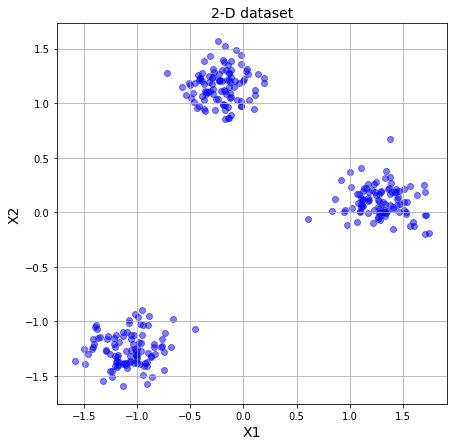

In [9]:
# Plot
plt.figure(figsize=(7, 7))
plt.scatter(X_sc[:, 0], X_sc[:, 1], edgecolor=None, alpha=0.5, c='b');

plt.title('2-D dataset', fontsize=14)
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)
plt.grid(True)

## 1.1 K-means Clustering

In [10]:
# Define k-means object
model = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=seed, n_jobs=4)

# Train
model.fit(X_sc);

In [11]:
# labels_ returns the labels for each sample
labels = model.labels_
print(np.bincount(labels))

[100 100 100]


In [12]:
# cluster_centers_ returns the coordinates of the centroids
centers = model.cluster_centers_
print(centers)

[[-0.21277029  1.15926337]
 [-1.07970061 -1.25787405]
 [ 1.2924709   0.09861068]]


In [13]:
# inertia_ returns sum of squared distances of samples to their closest clusters
# inertia_ is an unnormalized objective function
print(model.inertia_/X.shape[0])

0.060877197769653175


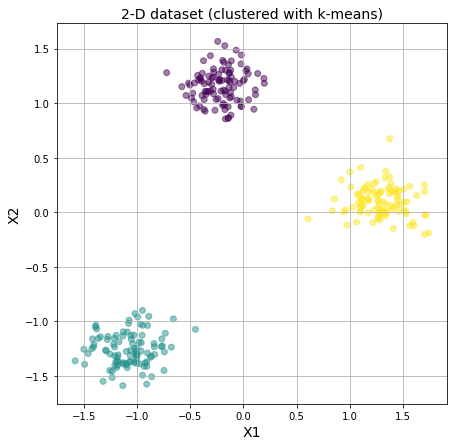

In [14]:
# Plot
plt.figure(figsize=(7, 7))
plt.scatter(X_sc[:, 0], X_sc[:, 1], edgecolor=None, alpha=0.5, c=labels);

plt.title('2-D dataset (clustered with k-means)', fontsize=14)
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)
plt.grid(True)

### How many *k* clusters to choose?

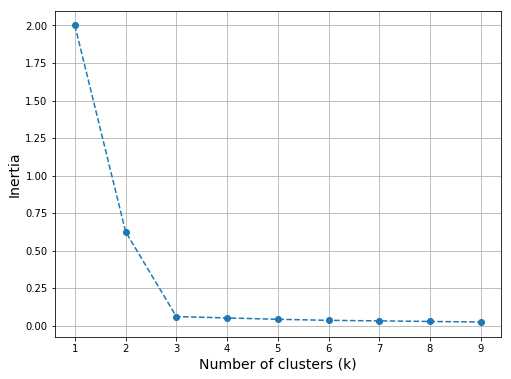

In [15]:
plot_kmeans_obj(X_sc, tot_clusters=10);

### Breast cancer dataset

In [16]:
# Load data
data = datasets.load_breast_cancer()
print(type(data))  # dictionary-like object
print(data.keys())

<class 'sklearn.utils.Bunch'>
dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [17]:
# print(data['DESCR'])  # README

In [18]:
# Get features and target
X = pd.DataFrame(data['data'], columns=data['feature_names'])
X = X[sorted(X.columns)]  # sort column by name

Y = pd.Series(data['target'])
Y = pd.Series(['Malignant' if v==0 else 'Benign' for v in Y.values]).astype('category') # convert to categorical

print(X.shape)
print(Y.shape)

(569, 30)
(569,)


In [19]:
display( X.iloc[:3,:7] )

,area error,compactness error,concave points error,concavity error,fractal dimension error,mean area,mean compactness
0,153.40,0.04904,0.01587,0.05373,0.006193,1001.0,0.27760
1,74.08,0.01308,0.01340,0.01860,0.003532,1326.0,0.07864
2,94.03,0.04006,0.02058,0.03832,0.004571,1203.0,0.15990


In [20]:
Y.value_counts()

Benign       357
Malignant    212
dtype: int64

In [21]:
# Scale features
scaler = StandardScaler()
scaler.fit(X)
X_sc = pd.DataFrame( scaler.transform(X), columns=X.columns )

In [22]:
# Define K-means model
kmeans = KMeans(n_clusters=2)

# Train model
kmeans.fit(X_sc);

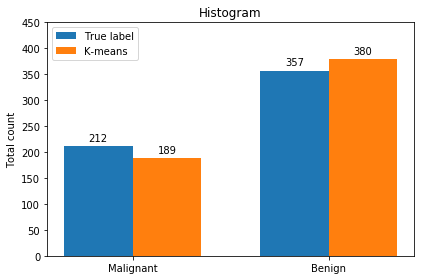

In [23]:
# Plot histogram of true class labels (malignant/benign) and cluster labels
k_means_bins = sorted(np.bincount(kmeans.labels_))
y_bins = sorted(Y.value_counts().values)
x_labels = ['Malignant', 'Benign']

plot_hists(k_means_bins, y_bins, x_labels=['Malignant', 'Benign'])

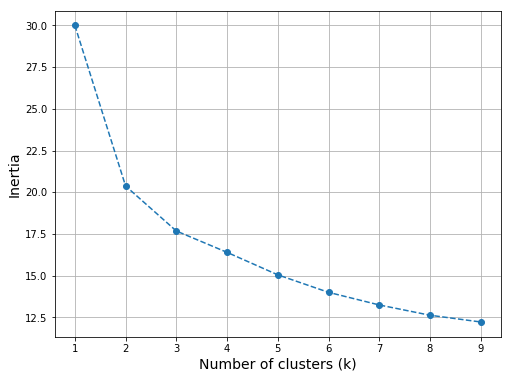

In [24]:
plot_kmeans_obj(X_sc, tot_clusters=10);

## 1.2 Hierarchical Clustering (agglomerative)

In [25]:
# Get a random subset of cancer data
samples = 30
idx = np.random.choice(np.arange(X_sc.shape[0]), size=samples)

X_sc_sub = X_sc.iloc[idx, :].values
Y_sub = Y[idx].values

print(X_sc_sub.shape)
print(Y_sub.shape)
print(pd.Series(Y_sub).value_counts())

(30, 30)
(30,)
Benign       20
Malignant    10
dtype: int64


In [26]:
# Define hierarchical clustering model
model = AgglomerativeClustering(affinity='euclidean', linkage='ward', compute_full_tree='auto')

# Train model
model.fit(X_sc_sub);

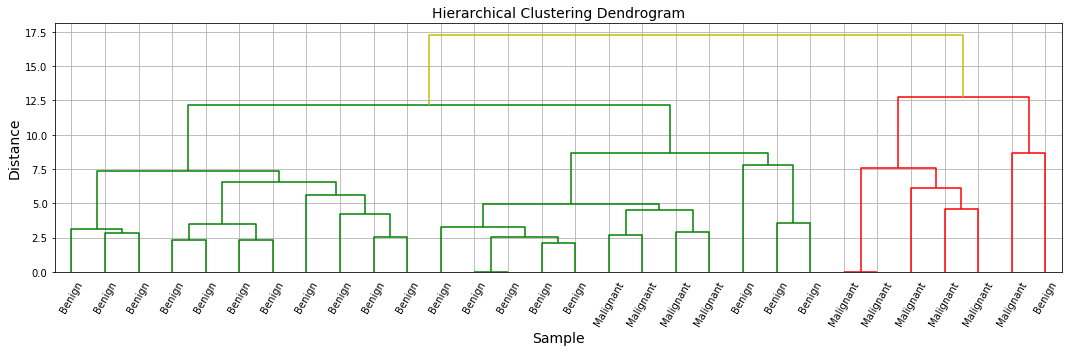

In [27]:
# We'll actually use a different module to plot the dendrogram
linkage_matrix = linkage(X_sc_sub, 'ward')

figure = plt.figure(figsize=(15, 5))
dendrogram(
    linkage_matrix,
    labels=Y_sub,
    leaf_rotation=60,
    above_threshold_color='y',
    color_threshold=15);

plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('Sample', fontsize=14)
plt.ylabel('Distance', fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()

# 2. Dimensionality Reduction

In [28]:
# Load data
X, Y = load_cancer_data()

# Scale data
scaler = StandardScaler()
scaler.fit(X)
X_sc = pd.DataFrame( scaler.transform(X), columns=X.columns )

## 2.1. PCA for data visualization

In [29]:
# Find pairs of features with highest correlation
corr = X_sc.corr('pearson').values
np.fill_diagonal(corr, val=0) # in-place operation
corr = pd.DataFrame(corr, index=X_sc.columns, columns=X_sc.columns)

corr_th = 0.99
x_ids, y_ids = np.where(corr > corr_th) # find indices that satisfy the condition
    
display(corr.iloc[x_ids, y_ids])

,mean radius,mean perimeter,worst radius,worst perimeter
mean perimeter,0.997855,0.000000,0.969476,0.970387
mean radius,0.000000,0.997855,0.969539,0.965137
worst perimeter,0.965137,0.970387,0.993708,0.000000
worst radius,0.969539,0.969476,0.000000,0.993708


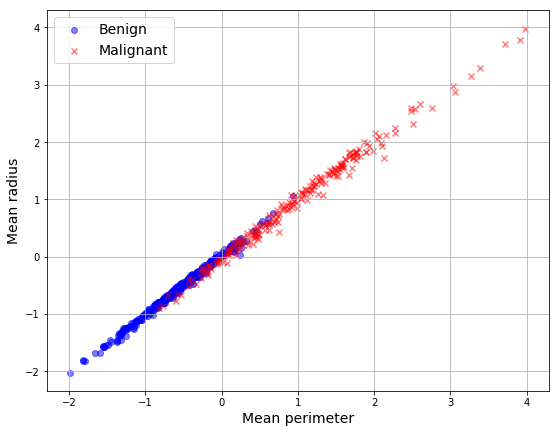

In [30]:
# Extract and plot two features with hight correlation
x_2d = X_sc[['mean perimeter', 'mean radius']]

plt.figure(figsize=(9,7))

# plt.scatter(xtr['mean perimeter'], xtr['mean radius'], alpha=0.7, marker='o');
plt.scatter(x_2d.loc[Y==1, 'mean perimeter'],
            x_2d.loc[Y==1, 'mean radius'],
            alpha=0.5, marker='o', c='b', edgecolor=None, label='Benign');

plt.scatter(x_2d.loc[Y==0, 'mean perimeter'],
            x_2d.loc[Y==0, 'mean radius'],
            alpha=0.5, marker='x', c='r', edgecolor=None, label='Malignant');

plt.xlabel('Mean perimeter', fontsize=14)
plt.ylabel('Mean radius', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)

In [31]:
# PCA with two highly correlated features
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_2d) # compute PCA and return the result

# Print the proportion of explained variances
print(pca.explained_variance_ratio_)

[0.99892764 0.00107236]


Explained variance by PCA components [1, 2]: [0.99893, 0.00107]


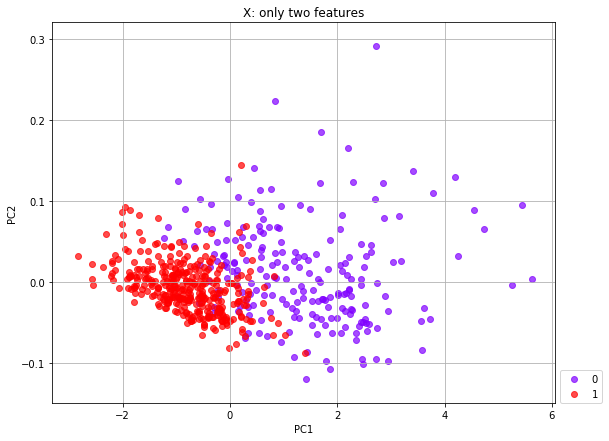

In [32]:
# Plot PCA
pca, _ = plot_pca( X=x_2d,
                   components=[1, 2],
                   color_vector=Y, title='X: only two features', figsize=(9,7) );

Explained variance by PCA components [1, 2]: [0.44272, 0.18971]


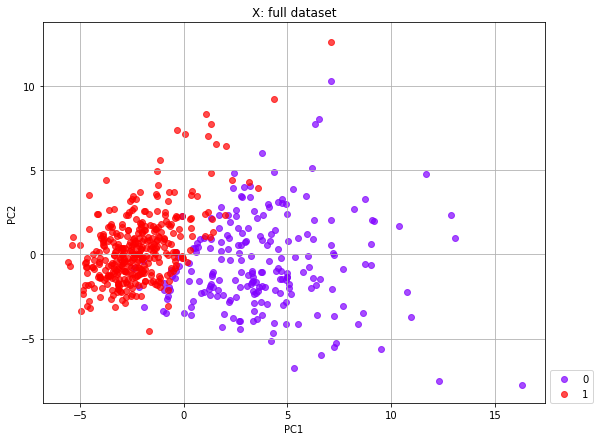

In [33]:
# Plot PCA of the full dataset
pca, _ = plot_pca( X=X_sc,
                   components=[1, 2],
                   color_vector=Y, title='X: full dataset', figsize=(9,7) );

## 2.2. PCA for data pre-processing

In [34]:
# Split dataset into train/test
xtr, xte, ytr, yte = train_test_split(X_sc, Y, test_size=0.2)

xtr.reset_index(drop=True, inplace=True)
xte.reset_index(drop=True, inplace=True)

print('X train shape:', xtr.shape)
print('X test shape: ', xte.shape)
print('Y train shape:', ytr.shape)
print('Y test shape: ', yte.shape)

X train shape: (455, 30)
X test shape:  (114, 30)
Y train shape: (455,)
Y test shape:  (114,)


In [35]:
# PCA xtr and xte
pca = PCA(n_components=xtr.shape[1])
xtr_pca = pca.fit_transform(xtr)  # PCA of the training set
xte_pca = pca.transform(xte)      # Apply the PCA transformation to the test set

print('X train PCA shape:', xtr_pca.shape)
print('X test PCA shape: ', xte_pca.shape)

X train PCA shape: (455, 30)
X test PCA shape:  (114, 30)


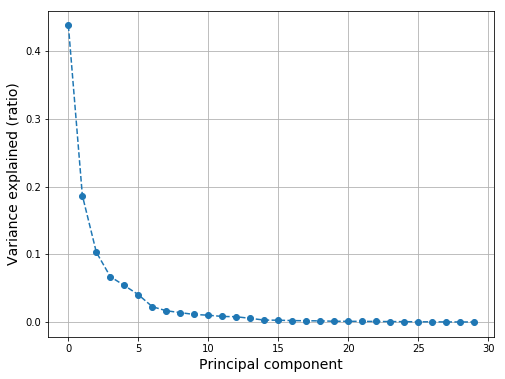

In [36]:
# Plot explained variance PCA
plt.figure(figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_, '--o')
plt.xlabel('Principal component', fontsize=14)
plt.ylabel('Variance explained (ratio)', fontsize=14)
plt.grid(True)

The features are highly redundant.

In [37]:
def pca_exp_var(pca, k):
    """ Print the total variance of the k principal components. """
    print (np.sum(pca.explained_variance_ratio_[:k]))

In [38]:
pca_exp_var(pca, k=10)

0.9525148848703552


### Random Forest Classifier

In [39]:
# Define Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, oob_score=True, min_samples_split=5)

# Train Classifier
rf.fit(xtr, ytr);

In [40]:
# Predict on test set (inference)
y_pred = rf.predict(xte)
f1 = f1_score(yte, y_pred)
print('F1 score:', f1)

F1 score: 0.9523809523809523


### Random Forest Classifier with *K* PCA components

How many PCA components should we retain?
- You decide that you want to keep cetain amount of explained variance (e.g., 0.9, 0.95, 0.99).
- Look for the "elbow" in the explained variance plot.
- Use *k* as a hyperparameter (choose *k* that improves the generalization of your supervised learning model.

In [41]:
# Chooose how many PCA components to use
k = 17
pca_exp_var(pca, k=k)

0.9912200657496999


In [42]:
# Get the data for k PCA components
xtr_pca_sub = xtr_pca[:, :k]  # PCA of the training set
xte_pca_sub = xte_pca[:, :k]  # PCA of the test set

print(xtr_pca_sub.shape)
print(xte_pca_sub.shape)

(455, 17)
(114, 17)


In [43]:
# Define Random Forest Classifier
rf_pca = RandomForestClassifier(n_estimators=100, oob_score=True, min_samples_split=5)

# Train Classifier
rf_pca.fit(xtr_pca_sub, ytr);

In [44]:
y_pred = rf_pca.predict(xte_pca_sub)
f1 = f1_score(yte, y_pred)
print('F1 score:', f1)

F1 score: 0.9589041095890412


# Pilot1 cancer data

In [45]:
# Load data
df = pd.read_csv('rna.csv')

In [46]:
# Extract rna and meta
rna_cols = [c for c in df.columns if 'GE_' in c]
rna = df[rna_cols]
meta = df.drop(columns=['Unnamed: 0'] + rna_cols)

print(rna.shape)
print(meta.shape)

(28, 942)
(28, 4)


In [47]:
# Show features (gene expression)
display(rna.iloc[:3, :7])

,GE_AARS,GE_ABCB6,GE_ABCC5,GE_ABCF1,GE_ABCF3,GE_ABHD4,GE_ABHD6
0,-0.195763,-0.005649,-0.797589,-0.059784,1.030595,0.825662,-0.508877
1,-0.235008,-0.197465,0.500168,0.349134,-0.030125,0.929008,-0.828963
2,-0.444318,-0.492567,-0.315565,-0.477221,0.154885,0.055263,-0.901240


In [48]:
# Show meta data
display(meta[:3])

,sample,src,csite,ctype
0,GDC.PR_PRAD.TCGA_HC_7232_05454.p,gdc,prostate,Prostate Adenocarcinoma
1,GDC.LC_LUAD.TCGA_93_A4JN_03457.p,gdc,lung,Lung Adenocarcinoma
2,GDC.PR_PRAD.TCGA_ZG_A9LY_08904.p,gdc,prostate,Prostate Adenocarcinoma


In [49]:
col = 'csite'
meta[col].value_counts()

lung        7
prostate    7
skin        7
breast      7
Name: csite, dtype: int64

Explained variance by PCA components [1, 2]: [0.21882, 0.18155]


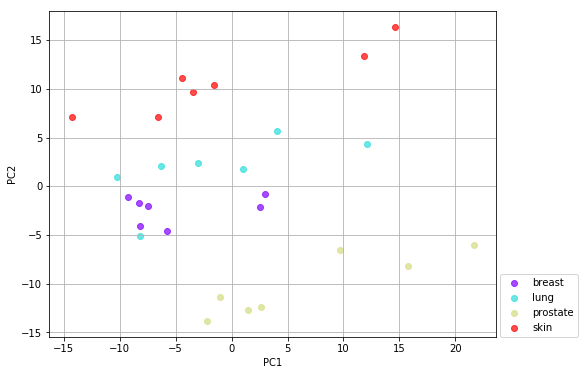

In [50]:
_, rna_pca = plot_pca(X=rna, components=[1,2], color_vector=meta[col])

### K-Means

In [51]:
n_clusters = 4

In [52]:
model = KMeans(n_clusters=n_clusters, init='k-means++', random_state=seed, n_jobs=4)
model.fit(rna)

labels = model.labels_
print('Labels bincount:', np.bincount(labels))

Labels bincount: [ 5  5  8 10]


### Hierarchical Clustering

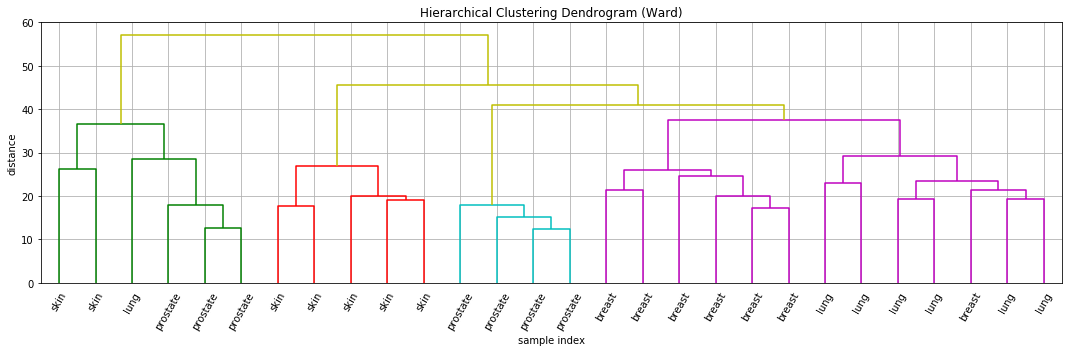

In [53]:
linkage_matrix = linkage(rna, 'ward')
figure = plt.figure(figsize=(15, 5))
dendrogram(
    linkage_matrix,
    color_threshold=40,
    labels=meta[col].values,
    leaf_rotation=60,
    show_contracted=True,
    above_threshold_color='y'
)
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.tight_layout()
plt.grid(True)
plt.show()

Hierarchical clustering makes it easier to find sub-populations in data.

# Keep learning

1. lagunita.stanford.edu/courses/HumanitiesSciences/StatLearning/Winter2016/course/
2. www.coursera.org/learn/ml-clustering-and-retrieval/
3. www.coursera.org/learn/machine-learning/home/week/8